In [1]:
# 1️⃣ Install / import everything
!pip install -q tensorflow   # If TF not already installed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Colab helper
from google.colab import files



In [2]:
# 2️⃣ Upload your dataset from local
# This will prompt you to choose the CSV file ʻsupply_chain_data.csvʼ
uploaded = files.upload()

# After upload, grab the filename automatically
csv_file = next(iter(uploaded.keys()))
print(f"Loaded file: {csv_file}")

# Load it into a DataFrame
data = pd.read_csv(csv_file)
data.head()


Saving supply_chain_data.csv to supply_chain_data.csv
Loaded file: supply_chain_data.csv


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [3]:
# 3️⃣ Data Cleaning & Feature Engineering

# Drop rows with any missing values
data = data.dropna()

# Convert any `Date` column if present
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data['Month']      = data['Date'].dt.month
    data['DayOfWeek']  = data['Date'].dt.dayofweek
    data['Quarter']    = data['Date'].dt.quarter
    data = data.drop(columns=['Date'])

# One-hot encode categorical features
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

print("Shape after encoding:", data.shape)


Shape after encoding: (100, 136)


In [18]:
# 4️⃣ Define target & features, then split + scale

# Use "Number of products sold" as the target
TARGET = 'Number of products sold'
if TARGET not in data.columns:
    raise ValueError(f"'{TARGET}' column missing in data!")

X = data.drop(columns=[TARGET])
y = data[TARGET]

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
# Save the training column order (used later in Streamlit inference)
import joblib
joblib.dump(X_train.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']

In [6]:
# 5️⃣ Build & train the neural-net

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(64,  activation='relu'),
    layers.Dense(32,  activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - loss: 293500.7188 - val_loss: 289229.4062
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 295485.0000 - val_loss: 288906.2500
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 295118.1562 - val_loss: 288596.7500
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 299703.7500 - val_loss: 288282.8750
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 321600.2500 - val_loss: 287971.5625
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 279150.4375 - val_loss: 287650.6875
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 311761.6562 - val_loss: 287310.2188
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 298980.5000 - val_loss: 286951.0625
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 300797.9688 - val_loss: 286556.8750
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 299539.2500 - val_loss: 286123.1875
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2846

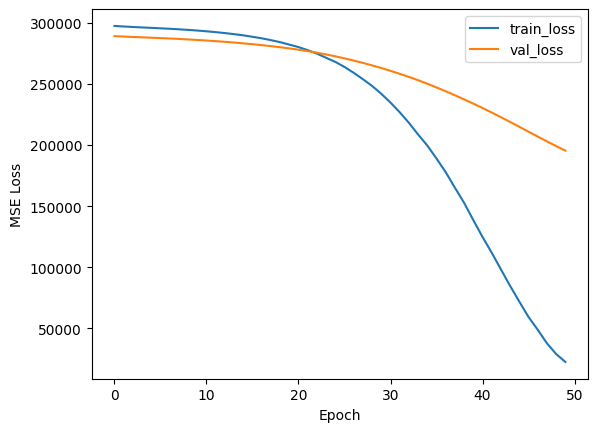

In [7]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
🔍 Test MSE: 128499.2031


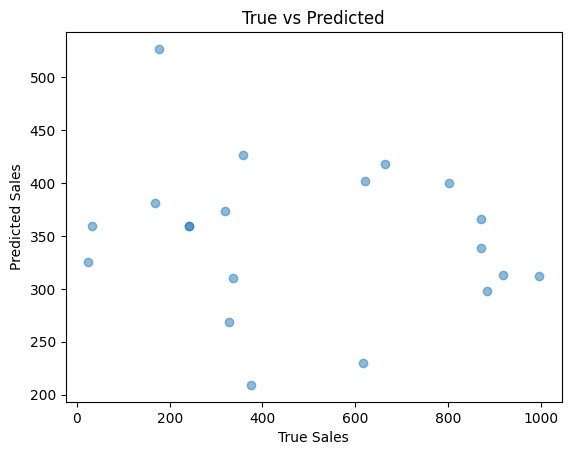

In [8]:
# 6️⃣ Evaluate on test set

preds = model.predict(X_test_scaled).flatten()
mse   = mean_squared_error(y_test, preds)
print(f"🔍 Test MSE: {mse:.4f}")

# Scatter true vs predicted
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('True vs Predicted')
plt.show()


In [10]:
# 7️⃣ Save & reload model + example prediction

# Save
model.save('demand_forecasting_model.keras')
print("Model saved to demand_forecasting_model.keras")

# Reload (to simulate future use)
loaded = keras.models.load_model('demand_forecasting_model.keras')

# Example: build a dummy input row of zeros (or fill with your own feature values)
example = np.zeros((1, X_train.shape[1]))
example_scaled = scaler.transform(example)
pred_sales = loaded.predict(example_scaled).flatten()[0]
print("Example predicted sales:", pred_sales)


Model saved to demand_forecasting_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Example predicted sales: 289.4633


In [12]:
files.download('demand_forecasting_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# 💾 Save & download the fitted scaler
import joblib
from google.colab import files

# Dump the scaler to disk
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved to scaler.pkl")

# Download the file to your local machine
files.download('scaler.pkl')



Scaler saved to scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from google.colab import files
files.download('feature_columns.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>